In [233]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split

In [5]:
# สมมติว่าคุณมีโฟลเดอร์ที่เก็บภาพตัวอักษรและใช้การตั้งชื่อแบบ image_label.png
image_folder = 'A_U'
images = []
labels = []

for filename in os.listdir(image_folder):
    if filename.endswith('.png'):  # ใช้ชนิดไฟล์ที่เหมาะสม
        # โหลดภาพ
        img = cv2.imread(os.path.join(image_folder, filename), cv2.IMREAD_GRAYSCALE)
        #img = cv2.resize(img, (28, 28))  # ปรับขนาดภาพ

        # ดึงป้ายกำกับจากชื่อไฟล์ เช่น A_0.png --> 0
        label = int(filename.split('_')[2].split('.')[0])

        images.append(img)
        labels.append(label)

# แปลงเป็น NumPy array และบันทึก
images = np.array(images)
labels = np.array(labels)

np.save('your_images.npy', images)
np.save('your_labels.npy', labels)

# Dataset

In [292]:
def directory_to_df(path : str):
    images = []
    labels = []
    chars = 'ABCDEFG'
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            img = cv2.imread(os.path.join(cls_path, img_path), cv2.IMREAD_GRAYSCALE)
            images.append(img)
            labels.append(cls_name)

    return (np.array(images), np.array(labels))

In [293]:
main_path = 'dataset_demo2/'
X, y = directory_to_df(main_path)                   
print(X.shape)
print(y)

(10419, 60, 40)
['A' 'A' 'A' ... 'C' 'C' 'C']


## Label Encoding

In [294]:
y, class_names = pd.factorize(y, sort=True)
print(y)
print(class_names)

[0 0 0 ... 2 2 2]
['A' 'B' 'C']


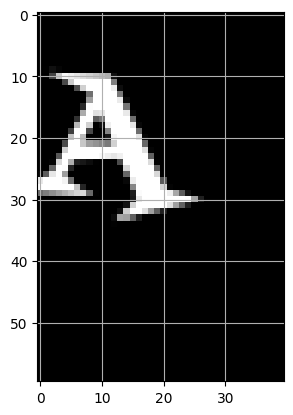

In [295]:
import matplotlib.pyplot as plt

idx = 6
img = df[idx]                       # 
plt.imshow(img, cmap=plt.cm.gray_r)      # actutal BG is black
# plt.imshow(img, cmap=plt.cm.gray) 

plt.grid()
plt.show()


## Train-test Split

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=41)

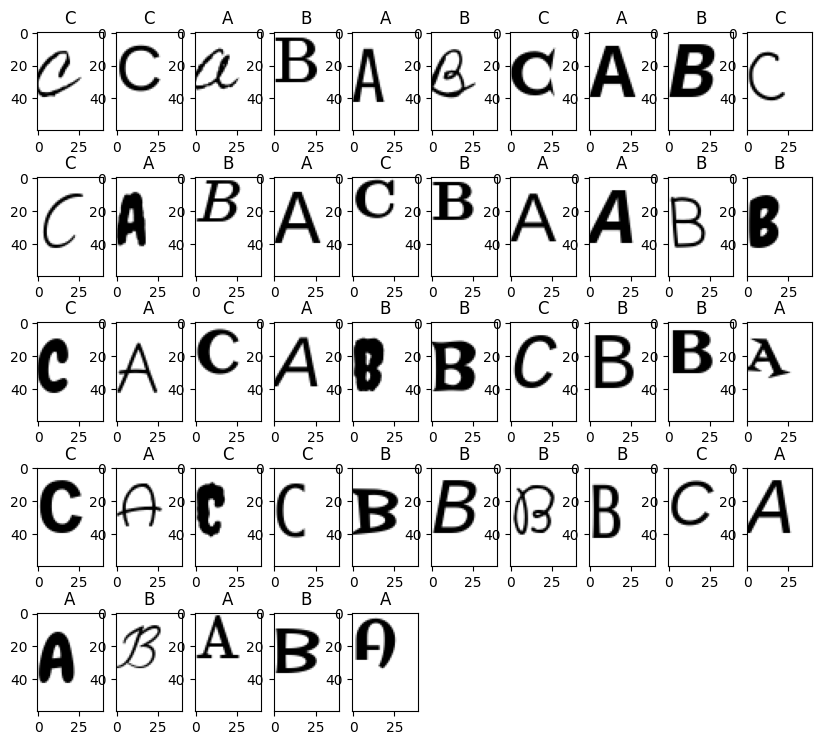

In [205]:
def visual_multi(i):
    nplots = 45
    fig = plt.figure(figsize=(10, 11)) 
    for j in range(nplots):
        plt.subplot(6, 10, j+1)
        plt.imshow(X_train[i+j], cmap=plt.cm.gray)
        plt.title(y_train[i+j])
        # plt.xticks([]); # plt.yticks([])
    plt.show()

visual_multi(0)

In [297]:
print(X_train.shape)
print(X_test.shape)

(7814, 60, 40)
(2605, 60, 40)


## Prepare Dataset (Re-shape the Structure)

In [298]:
X_train = np.expand_dims(X_train, -1)     # run only Once! or  np.squeeze(X_train)
X_test = np.expand_dims(X_test, -1)

In [299]:
print(X_train.shape)
print(X_test.shape) 

(7814, 60, 40, 1)
(2605, 60, 40, 1)


In [300]:
# Normalize
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [301]:
np.min(X_train), np.max(X_train)

(0.0, 1.0)

In [253]:
num_samples = 60         # number of samples

X_train = X_train[:num_samples]
y_train = y_train[:num_samples]

X_test = X_test[:num_samples]
y_test = y_test[:num_samples]

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(y_train)

plt.show()
del sns, warnings

In [302]:
print('Train: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test: X={}, y={}'.format(X_test.shape, y_test.shape))

Train: X=(7814, 60, 40, 1), y=(7814,)
Test: X=(2605, 60, 40, 1), y=(2605,)


# Create Model

In [303]:
num_classes = len(np.unique(y_train))
num_classes     # total classes

3

In [304]:
in_shape = X_train.shape[1:]
in_shape

(60, 40, 1)

In [305]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten #, Dropout

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=in_shape)) 
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu')) 

model.add(Dense(num_classes, activation='softmax'))

In [306]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 58, 38, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 29, 19, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 27, 17, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 13, 8, 64)        0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 6656)              0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [307]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [308]:
# สมมติว่า y_train และ y_test มีค่าป้ายกำกับที่เป็น string
y_train = np.array([int(label) for label in y_train])
y_test = np.array([int(label) for label in y_test])

In [309]:
import time
start = time.time()

history = model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1, validation_split=0.15) 

end = time.time()

print("Time Taken: {:.2f} minutes".format((end - start)/60))

Epoch 1/10
52/52 [==============================] - 1s 9ms/step - loss: 0.5103 - accuracy: 0.7979 - val_loss: 0.2563 - val_accuracy: 0.9045
Epoch 2/10
52/52 [==============================] - 0s 5ms/step - loss: 0.2039 - accuracy: 0.9199 - val_loss: 0.1660 - val_accuracy: 0.9275
Epoch 3/10
52/52 [==============================] - 0s 5ms/step - loss: 0.1453 - accuracy: 0.9386 - val_loss: 0.1494 - val_accuracy: 0.9327
Epoch 4/10
52/52 [==============================] - 0s 5ms/step - loss: 0.1158 - accuracy: 0.9491 - val_loss: 0.1228 - val_accuracy: 0.9412
Epoch 5/10
52/52 [==============================] - 0s 5ms/step - loss: 0.1051 - accuracy: 0.9535 - val_loss: 0.1212 - val_accuracy: 0.9437
Epoch 6/10
52/52 [==============================] - 0s 5ms/step - loss: 0.0939 - accuracy: 0.9563 - val_loss: 0.1152 - val_accuracy: 0.9454
Epoch 7/10
52/52 [==============================] - 0s 5ms/step - loss: 0.0833 - accuracy: 0.9615 - val_loss: 0.1334 - val_accuracy: 0.9488
Epoch 8/10
52/52 [==

In [320]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: {:.3f}'.format(score[1]))

82/82 [==============================] - 0s 3ms/step - loss: 0.0964 - accuracy: 0.9559
Accuracy: 0.956


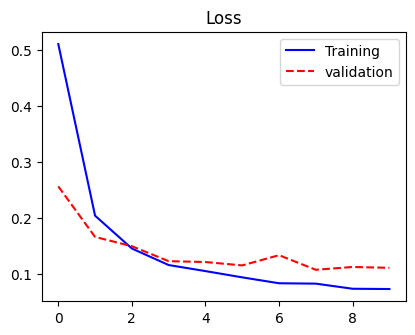

In [321]:
plt.figure(figsize=(4.7, 3.5))
plt.plot(history.history['loss'], color='b', label="Training")
plt.plot(history.history['val_loss'], 'r--', label="validation")
plt.title('Loss')
plt.legend()
plt.show()

# Predict an image

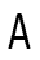

In [325]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import rgb_to_grayscale

# conda
img = load_img('test/A.png', target_size=(60, 40))
img


In [326]:
from PIL import Image, ImageOps

img = ImageOps.invert(img)
img = img_to_array(img)
img = rgb_to_grayscale(img)

print('shape=',img.shape)
print('max pixel value=',np.max(img))

img = img /255.0
print('max pixel value=',np.max(img))

img = np.expand_dims(img, axis=0)
img.shape

shape= (60, 40, 1)
max pixel value= 254.97452
max pixel value= 0.99990004


(1, 60, 40, 1)

In [327]:
y_pred = model.predict(img)
print(y_pred.round(3))

1/1 [==============================] - 0s 238ms/step
[[0.997 0.    0.002]]


In [328]:
predicted = np.argmax(y_pred, -1) 
print(predicted)

[0]


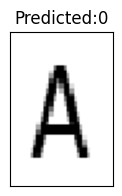

In [330]:
plt.figure(figsize=(2, 2))
plt.imshow(img[0].reshape(60, 40), cmap=plt.cm.gray_r)
plt.title('Predicted:{}'. format(predicted[0]))
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
model.save('digitmodel.h5')